In [1]:
import sys
sys.path.append('/home/tcalo3/projects/project6')
sys.path.append('/home/tcalo3/projects/project6/src/modules/components/ganspace')

In [3]:
# Load model
from IPython.utils import io
import ipywidgets as widgets
from PIL import Image
import imageio
from models import get_instrumented_model
from decomposition import get_or_compute
from config import Config
from skimage import img_as_ubyte
from PIL import Image
import numpy as np
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
import warnings
warnings.filterwarnings('ignore')

# Speed up computation
torch.autograd.set_grad_enabled(False)
torch.backends.cudnn.benchmark = True

# Specify model to use
config = Config(
  model='StyleGAN',
  layer='g_mapping.dense7',
  output_class='ffhq',
  components=32,
  use_w=True,
  batch_size=5_000, # style layer quite small
)

inst = get_instrumented_model(config.model, config.output_class,
                              config.layer, torch.device('cuda'), use_w=config.use_w)

path_to_components = get_or_compute(config, inst)

model = inst.model

In [4]:
#@title Load a component at random
path_to_components="/home/tcalo3/projects/project6/src/modules/components/ganspace/cache/components/stylegan-ffhq_g_mapping.dense7_pca-full_c32_n300000_w.npz"
comps = np.load(path_to_components)
lst = comps.files
latent_dirs = []
latent_stdevs = []

load_activations = False

for item in lst:
    if load_activations:
      if item == 'act_comp':
        for i in range(comps[item].shape[0]):
          latent_dirs.append(comps[item][i])
      if item == 'act_stdev':
        for i in range(comps[item].shape[0]):
          latent_stdevs.append(comps[item][i])
    else:
      if item == 'lat_comp':
        for i in range(comps[item].shape[0]):
          latent_dirs.append(comps[item][i])
      if item == 'lat_stdev':
        for i in range(comps[item].shape[0]):
          latent_stdevs.append(comps[item][i])

#load one at random
num = np.random.randint(32)
random_dir = latent_dirs[num]
random_dir_stdev = latent_stdevs[num]
print(f'Loaded Component No. {num}')

Loaded Component No. 7


In [6]:
from src.modules.metrics.models.facenet import FaceNetModel
def sample_pca_space(n_samples, pca_components, pca_stdevs):
    random_samples = np.random.randn(n_samples, pca_components) * pca_stdevs
    return random_samples

def reconstruct_from_pca(pca_samples, pca_components, data_mean):
    original_data = np.dot(pca_samples, pca_components.T) + data_mean
    return original_data


def project_to_pca(new_data, pca_components, data_mean):
    centered_data = new_data - data_mean
    
    pca_projection = np.dot(centered_data, pca_components)
    return pca_projection

with torch.set_grad_enabled(False):
    facenet = FaceNetModel().eval()
    pass

def objective_function(X,target):
    target_out = model.sample_np(target)
    target_image = Image.fromarray((target_out * 255).astype(np.uint8))
    target_resized_image = target_image.resize((160, 160), Image.NEAREST)
    target_tensor = torch.from_numpy(np.array(target_resized_image)).unsqueeze(0).permute(0, 3, 1, 2)
    target_embedding = facenet(target_tensor.float())

    X = reconstruct_from_pca(X,comps['lat_comp'][:,0,:].T,comps['lat_mean'])
    X_out = model.sample_np(X.astype(np.float32))
    X_image = Image.fromarray((X_out * 255).astype(np.uint8))
    X_resized_image = X_image.resize((160, 160), Image.NEAREST)
    X_tensor = torch.from_numpy(np.array(X_resized_image)).unsqueeze(0).permute(0, 3, 1, 2)
    X_embedding = facenet(X_tensor.float())

    return torch.nn.functional.cosine_similarity(target_embedding, X_embedding, dim=1)


target = model.sample_latent(1).cpu().detach().numpy() 


# Generate initial training data
pca_sample = sample_pca_space(1,comps['lat_comp'].shape[0],comps['lat_stdev'] )
train_x = torch.tensor(pca_sample)


In [64]:

target = model.sample_latent(1).cpu().detach().numpy() 


# Generate initial training data
pca_sample = sample_pca_space(1,comps['lat_comp'].shape[0],comps['lat_stdev'] )
train_x = torch.tensor(pca_sample)
train_y = torch.tensor([objective_function(x,target) for x in pca_sample]).unsqueeze(-1)


Bar desc:   0%|          | 0/1000 [03:51<?, ?it/s]


In [60]:
import numpy as np
import math


class UpperConfidenceBound:
    def __init__(self, c, mab):
        self.mab = mab
        self.num_arms = mab.num_arms
        self.Q_a = np.zeros(self.num_arms)
        self.N_a = np.zeros(self.num_arms)
        self.total_reward = 0
        self.c = c

    def run(self, max_steps, debug=False):
        # Store reward at each t
        self.reward_t = np.zeros(max_steps)
        num_steps = 1
        while(num_steps < max_steps):
            arm_to_pull = self.select_action(num_steps)
            current_reward = self.mab.pull_arm(
                arm_to_pull)
            self.total_reward += current_reward
            self.reward_t[num_steps] = current_reward
            if(debug):
                print(f'Current reward : {self.total_reward}')
            self.N_a[arm_to_pull] += 1
            self.Q_a[arm_to_pull] = self.Q_a[arm_to_pull] + \
                (1 / self.N_a[arm_to_pull]) * \
                (current_reward - self.Q_a[arm_to_pull])
            num_steps += 1
        return self.reward_t, self.total_reward

    def select_action(self, t):
        # Estimate upper bound and choose action with largest estimated upper bound
        arm_to_pull = np.argmax(
            self.Q_a+self.c*np.sqrt(math.log(t)/self.N_a))
        return arm_to_pull

    # Clear vars
    def clear(self):
        self.Q_a = np.zeros(self.num_arms)
        self.N_a = np.zeros(self.num_arms)
        self.total_reward = 0

import numpy as np
import math


class MultiArmBandit:
    def __init__(self, num_arms, debug=False):
        self.num_arms = num_arms
        self.possible_actions = np.zeros(num_arms)
        self.q_a = np.zeros(num_arms)

        # Ini mean values
        for i in np.arange(num_arms):
            self.q_a[i] = np.random.normal(loc=0, scale=math.sqrt(1))

    def pull_arm(self, index_arm, debug=False):
        r_t = np.random.normal(loc=self.q_a[index_arm], scale=math.sqrt(1))
        return r_t

    def print_actions(self):
        print(f'Possible actions - {self.possible_actions}')

In [111]:
import numpy as np
import math
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.models.pairwise_gp import PairwiseGP, PairwiseLaplaceMarginalLogLikelihood

class BanditBO:
    def __init__(self, num_dimensions, pca_components, pca_stdevs, data_mean, model, target,bounds, objective_function):
        self.num_dimensions = num_dimensions
        self.pca_components = pca_components
        self.pca_stdevs = pca_stdevs
        self.data_mean = data_mean
        self.model = model
        self.target = target
        self.objective_function = objective_function
        self.bounds=bounds
        self.bandit = MultiArmBandit(num_dimensions)
        self.ucb = UpperConfidenceBound(c=0.5, mab=self.bandit)
        
        self.train_x = None
        self.train_y = None
        self.pairwise_gp = None
        
    def run(self, num_iterations):
        for i in range(num_iterations):
            # Select dimension to explore using UCB
            dimension = self.ucb.select_action(i+1)
            
            # Sample from PCA space
            pca_sample = sample_pca_space(1, self.pca_components.shape[0], self.pca_stdevs)
            
            # Optimize acquisition function in the selected dimension
            if self.train_x is None:
                train_x_dim = torch.zeros(1, self.num_dimensions)
            else:
                train_x_dim = self.train_x[-1].clone()
            train_x_dim[0, dimension] = pca_sample[0, dimension]
            
            # Reconstruct from PCA space
            train_x_reconstructed = reconstruct_from_pca(train_x_dim.numpy(), self.pca_components[:,0,:].T, self.data_mean)
            
            # Evaluate objective function
            train_y_new = self.objective_function(train_x_dim.numpy(), self.target)
            
            # Update training data
            if self.train_x is None:
                self.train_x = train_x_dim.unsqueeze(0)
                self.train_y = train_y_new.unsqueeze(0)
            else:
                self.train_x = torch.cat([self.train_x, train_x_dim.unsqueeze(0)], dim=0)
                self.train_y = torch.cat([self.train_y, train_y_new.unsqueeze(0)], dim=0)
            
            # Fit pairwise GP model
            self.pairwise_gp = PairwiseGP(self.train_x, self.train_y)
            mll = PairwiseLaplaceMarginalLogLikelihood(self.pairwise_gp.likelihood, self.pairwise_gp)
            fit_gpytorch_model(mll)
            
            # Optimize acquisition function
            acq_func = ExpectedImprovement(self.pairwise_gp, best_f=self.train_y.max().item())
            candidate, _ = optimize_acqf(
                acq_function=acq_func,
                bounds=self.bounds,
                q=1,
                num_restarts=10,
                raw_samples=512,
            )
            
            # Update bandit reward
            reward = 1 if self.train_y[-1] > self.train_y[-2] else 0
            self.bandit.q_a[dimension] += reward
            
            # Print progress
            print(f"Iteration {i+1}/{num_iterations}, Dimension: {dimension}, Reward: {reward}")
        
        # Return best solution
        best_index = self.train_y.argmax()
        return self.train_x[best_index], self.train_y[best_index]

# Define the bounds of your optimization based on PCA variances (assuming normality and using some scale factor)
bounds = torch.stack([
    torch.tensor([-1 * stdev for stdev in latent_stdevs]),  # Lower bounds
    torch.tensor([1 * stdev for stdev in latent_stdevs])   # Upper bounds
])


# Usage example
bandit_bo = BanditBO(
    num_dimensions=comps['lat_comp'].shape[0], 
    pca_components=comps['lat_comp'],
    pca_stdevs=comps['lat_stdev'],
    data_mean=comps['lat_mean'],
    model=model,
    target=target,
    bounds=bounds,
    objective_function=objective_function
)



best_solution, best_value = bandit_bo.run(num_iterations=100)

RuntimeError: shape '[-1, 1, 2]' is invalid for input of size 1

In [ ]:
# Optimization loop
from tqdm import trange
t = trange(1000, desc='Bar desc', leave=True)

In [ ]:
# Define the bounds of your optimization based on PCA variances (assuming normality and using some scale factor)
bounds = torch.stack([
    torch.tensor([-1 * stdev for stdev in latent_stdevs]),  # Lower bounds
    torch.tensor([1 * stdev for stdev in latent_stdevs])   # Upper bounds
])




In [8]:
num_dimensions = comps['lat_comp'].shape[0]
pca_components=comps['lat_comp']
pca_stdevs=comps['lat_stdev']
data_mean=comps['lat_mean']
train_x = None
train_y = None
pairwise_gp = None

bandit = MultiArmBandit(num_dimensions)
ucb = UpperConfidenceBound(c=0.5, mab=bandit)




NameError: name 'MultiArmBandit' is not defined

In [7]:
sample_pca_space(1, pca_components.shape[0], pca_stdevs)

NameError: name 'pca_components' is not defined

In [75]:
dimension = ucb.select_action(i+1)
pca_sample = sample_pca_space(1, pca_components.shape[0], pca_stdevs)

In [79]:
# Optimize acquisition function in the selected dimension
if train_x is None:
    train_x_dim = torch.zeros(1,num_dimensions)
else:
    train_x_dim = train_x[-1].clone()
train_x_dim[0, dimension] = pca_sample[0, dimension]

In [105]:
comps['lat_mean'].shape

(1, 512)

In [107]:
train_x_reconstructed = reconstruct_from_pca(train_x_dim.numpy(),pca_components[:,0,:].T, data_mean)


In [109]:
train_y_new = objective_function(train_x_reconstructed, target)


ValueError: shapes (1,512) and (32,512) not aligned: 512 (dim 1) != 32 (dim 0)

In [ ]:
for i in range(num_iterations):
    print(i)
    # Select dimension to explore using UCB
    dimension = self.ucb.select_action(i+1)
    
    # Sample from PCA space
    pca_sample = sample_pca_space(1, self.pca_components.shape[0], self.pca_stdevs)
    
    # Optimize acquisition function in the selected dimension
    if self.train_x is None:
        train_x_dim = torch.zeros(1, self.num_dimensions)
    else:
        train_x_dim = self.train_x[-1].clone()
    train_x_dim[0, dimension] = pca_sample[0, dimension]
    
    # Reconstruct from PCA space
    train_x_reconstructed = reconstruct_from_pca(train_x_dim.numpy(), self.pca_components[:,0,:].T, self.data_mean)
    
    # Evaluate objective function
    train_y_new = self.objective_function(train_x_reconstructed, self.target)
    
    # Update training data
    if self.train_x is None:
        self.train_x = train_x_dim.unsqueeze(0)
        self.train_y = train_y_new.unsqueeze(0)
    else:
        self.train_x = torch.cat([self.train_x, train_x_dim.unsqueeze(0)], dim=0)
        self.train_y = torch.cat([self.train_y, train_y_new.unsqueeze(0)], dim=0)
    
    # Fit pairwise GP model
    self.pairwise_gp = PairwiseGP(self.train_x, self.train_y)
    mll = PairwiseLaplaceMarginalLogLikelihood(self.pairwise_gp.likelihood, self.pairwise_gp)
    fit_gpytorch_model(mll)
    
    # Optimize acquisition function
    acq_func = ExpectedImprovement(self.pairwise_gp, best_f=self.train_y.max().item())
    candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=512,
    )
    
    # Update bandit reward
    reward = 1 if self.train_y[-1] > self.train_y[-2] else 0
    self.bandit.q_a[dimension] += reward
    
    # Print progress
    print(f"Iteration {i+1}/{num_iterations}, Dimension: {dimension}, Reward: {reward}")

# Return best solution
best_index = self.train_y.argmax()
return self.train_x[best_index], self.train_y[best_index]

# Define the bounds of your optimization based on PCA variances (assuming normality and using some scale factor)
bounds = torch.stack([
torch.tensor([-1 * stdev for stdev in latent_stdevs]),  # Lower bounds
torch.tensor([1 * stdev for stdev in latent_stdevs])   # Upper bounds
])

In [43]:


train_x = train_x.double()  # or train_x.double() for float64
train_y = train_y.double()  # or train_y.double() for float64
with torch.enable_grad():

    gp_model = SingleTaskGP(train_x, train_y)


    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)


    fit_gpytorch_mll(mll)

# Define the bounds of your optimization based on PCA variances (assuming normality and using some scale factor)
bounds = torch.stack([
    torch.tensor([-1 * stdev for stdev in latent_stdevs]),  # Lower bounds
    torch.tensor([1 * stdev for stdev in latent_stdevs])   # Upper bounds
])

bounds = bounds.double()

# Define UCB acquisition function
beta = 3  # Adjust beta based on your needs for exploration vs. exploitation

objective_values = []


for i in t:
    UCB = qUpperConfidenceBound(gp_model, beta=beta)
    with torch.enable_grad():
        candidates, _ = optimize_acqf(
            acq_function=UCB,
            bounds=bounds,
            q=1,  # One new candidate point
            num_restarts=5,
            raw_samples=20  # Initial random points
        )

        # Evaluate new candidate point
        new_y = objective_function(candidates.detach().numpy(),target)
        objective_values.append(new_y)

        # Update training data
        train_x = torch.cat([train_x, candidates]).detach()
        train_y = torch.cat([train_y, new_y.unsqueeze(0)]).detach()

        # Update the model
        gp_model = SingleTaskGP(train_x, train_y)
        mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
        fit_gpytorch_mll(mll)
    t.set_description(f"current value {new_y[0]:.2f}")

current value 0.94:   4%|▍         | 43/1000 [01:32<34:13,  2.15s/it]  


KeyboardInterrupt: 

In [ ]:
import numpy as np
import math

class MultiArmBandit:
    def __init__(self, num_arms, debug=False):
        self.num_arms = num_arms
        self.possible_actions = np.zeros(num_arms)
        self.q_a = np.zeros(num_arms)

        # Ini mean values
        for i in np.arange(num_arms):
            self.q_a[i] = np.random.normal(loc=0, scale=math.sqrt(1))

    def pull_arm(self, index_arm, debug=False):
        r_t = np.random.normal(loc=self.q_a[index_arm], scale=math.sqrt(1))
        return r_t

    def print_actions(self):
        print(f'Possible actions - {self.possible_actions}')

        import numpy as np


class UpperConfidenceBound:
    def __init__(self, c, mab):
        self.mab = mab
        self.num_arms = mab.num_arms
        self.Q_a = np.zeros(self.num_arms)
        self.N_a = np.zeros(self.num_arms)
        self.total_reward = 0
        self.c = c

    def run(self, max_steps, debug=False):
        # Store reward at each t
        self.reward_t = np.zeros(max_steps)
        num_steps = 1
        while(num_steps < max_steps):
            arm_to_pull = self.select_action(num_steps)
            current_reward = self.mab.pull_arm(
                arm_to_pull)
            self.total_reward += current_reward
            self.reward_t[num_steps] = current_reward
            if(debug):
                print(f'Current reward : {self.total_reward}')
            self.N_a[arm_to_pull] += 1
            self.Q_a[arm_to_pull] = self.Q_a[arm_to_pull] + \
                (1 / self.N_a[arm_to_pull]) * \
                (current_reward - self.Q_a[arm_to_pull])
            num_steps += 1
        return self.reward_t, self.total_reward

    def select_action(self, t):
        # Estimate upper bound and choose action with largest estimated upper bound
        arm_to_pull = np.argmax(
            self.Q_a+self.c*np.sqrt(math.log(t)/self.N_a))
        return arm_to_pull

    # Clear vars
    def clear(self):
        self.Q_a = np.zeros(self.num_arms)
        self.N_a = np.zeros(self.num_arms)
        self.total_reward = 0

In [92]:
target_out = model.sample_np(target)
target_image = Image.fromarray((target_out * 255).astype(np.uint8))
target_resized_image = target_image.resize((160, 160), Image.NEAREST)

X = reconstruct_from_pca(candidates.detach().numpy(),comps['lat_comp'][:,0,:].T,comps['lat_mean'])
X_out = model.sample_np(X.astype(np.float32))
X_image = Image.fromarray((X_out * 255).astype(np.uint8))
X_image = X_image.resize((160, 160), Image.NEAREST)

In [93]:
reconstruct_from_pca(candidates.detach().numpy(),comps['lat_comp'][:,0,:].T,comps['lat_mean']).shape

(1, 512)

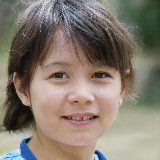

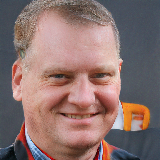

(None, None)

In [49]:
display(X_image),display(target_resized_image)


In [50]:
objective_function(candidates.detach().numpy(),target)

tensor([0.9462])